# Predicting Delta Airlines Closing price using Multivariate RNN model

##Part-1 Data loading and preparation

In [45]:

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from datetime import date, timedelta, datetime # Date Functions

import tensorflow as tf 
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 

import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

import yfinance as yf # convenient package for downloading stock data from yahoo finance

# for reproducibility; set the following seeds (note, that the results may still vary slightly. Also, the stock data is is up to the latest date, so the results may vary slightly over time)
np.random.seed(1)
tf.random.set_seed(1)

##Load the Time Series Data

In [46]:
STOCK_NAME = 'Delta Airlines' # change this to any stock ticker you want to analyse (see yahoo finane for a list of tickers)
STOCK_SYMBOL = 'DAL' # change this to any stock ticker you want to analyse (see yahoo finane for a list of tickers)
years = 20 # number of years of data to download

In [47]:
# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365*years)).strftime("%Y-%m-%d")
print("Date range", start_date, "to", end_date)

# Get stock quote data
stockname = STOCK_NAME
symbol = STOCK_SYMBOL

# Use yahoo finance to download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
#save the data
df.to_csv('DeltaAirlines_stock_data.csv')
# View the first 5 rows of the data
df.head()

Date range 2003-05-10 to 2023-05-05
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-05-03,21.750000,21.950001,20.549999,20.719999,18.404472,8052800
2007-05-04,21.250000,21.350000,20.700001,20.980000,18.635420,5437300
2007-05-07,21.200001,21.290001,20.200001,20.360001,18.084709,2646300
2007-05-08,20.000000,20.000000,19.299999,19.629999,17.436281,4166100
2007-05-09,19.750000,20.200001,19.629999,19.790001,17.578405,7541100


In [48]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-28,33.450001,34.389999,33.240002,34.310001,34.310001,11108900
2023-05-01,34.430000,35.160000,34.180000,34.720001,34.720001,9901400
2023-05-02,34.500000,34.669998,33.889999,34.529999,34.529999,10014900
2023-05-03,34.529999,34.810001,34.049999,34.130001,34.130001,11166100
2023-05-04,33.950001,33.980000,32.680000,33.080002,33.080002,11680600


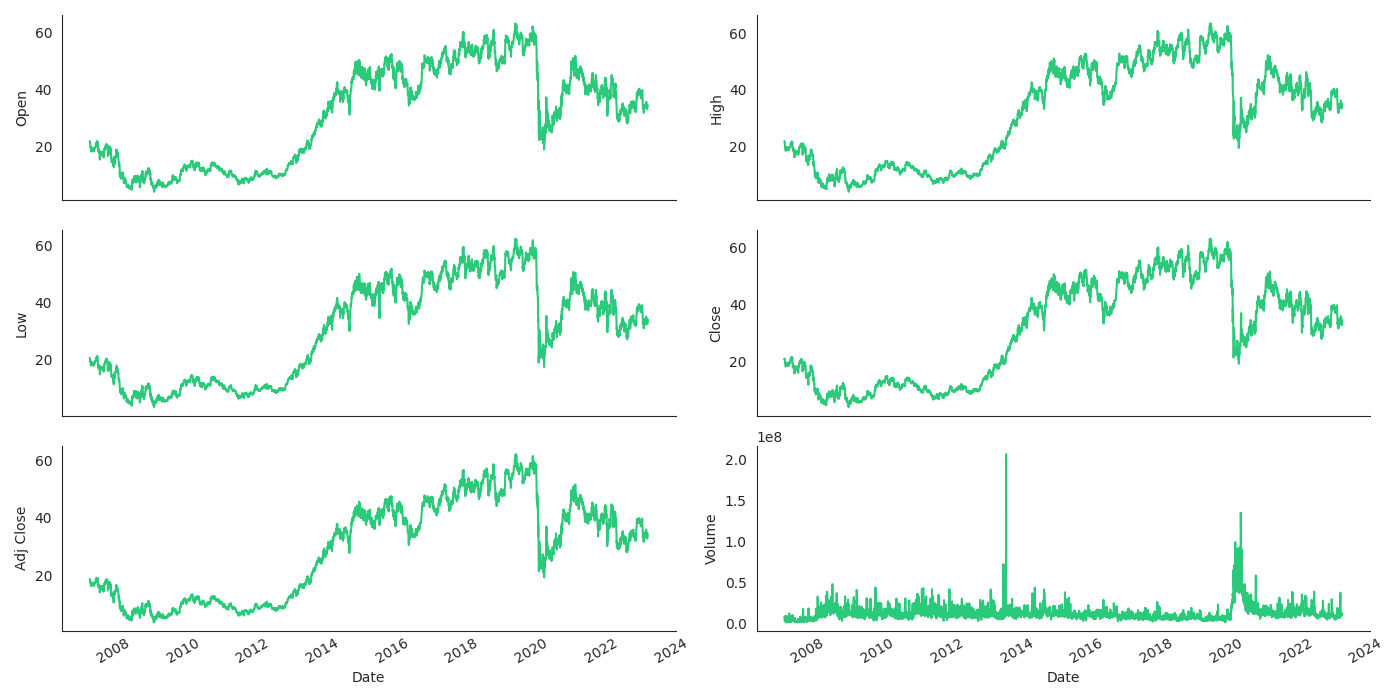

In [49]:
ncols = 2
nrows = math.ceil(df.shape[1] / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7)) # sharex allows for all subplots to have the same x-axis
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)  # plot the i-th column of the dataframe
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # AutoDateFormatter class figures out the best format to use for the date
fig.tight_layout()
plt.show()

Volume value is large when compared to other features so i was not consider Volumn feature

In [50]:
#train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = [
    'Close', 'Open', 'High', 'Low',

]
# Create the dataset with features and filter the data to the list of FEATURES
df = df[FEATURES]

#df['Date'] = df.index # may add this later to include dates as x-axis in final plot

# Print the tail of the dataframe
df.head()

,Close,Open,High,Low
Date,,,,
2007-05-03,20.719999,21.750000,21.950001,20.549999
2007-05-04,20.980000,21.250000,21.350000,20.700001
2007-05-07,20.360001,21.200001,21.290001,20.200001
2007-05-08,19.629999,20.000000,20.000000,19.299999
2007-05-09,19.790001,19.750000,20.200001,19.629999



## Preparing data for a recurrent neural network
A recurrent neural network requires a 3D array as input. The first dimension is the number of samples, the second dimension is the number of time steps, and the third dimension is the number of features. The following code creates a 3D array with 3 samples, 3 time steps, and 4 feature.

Let's say we want to predict the next day after sequence of 3 days.

Therefore, our first sample will be the feature values for the first 3 rows of the dataframe, and the second sample will be the next three rows starting at the second row, etc.

Let's begin by converting the dataframe to a numpy array.

In [51]:
#converting dataframe to numpy array data
df.to_numpy()

array([[20.71999931, 21.75      , 21.95000076, 20.54999924],
       [20.97999954, 21.25      , 21.35000038, 20.70000076],
       [20.36000061, 21.20000076, 21.29000092, 20.20000076],
       ...,
       [34.52999878, 34.5       , 34.66999817, 33.88999939],
       [34.13000107, 34.52999878, 34.81000137, 34.04999924],
       [33.08000183, 33.95000076, 33.97999954, 32.68000031]])

The 2D data above is not not our input to the recurrent network - we have four feaures, but no observations. Observations will be the sequences length number of rows.

In [52]:
#defining function to create sequences
def create_sequences(data, seq_length):
    obs = []
    print(obs)    
    for i in range(len(data)-seq_length-1):
        obs.append(data[i:(i+seq_length)+1])
    return np.array(obs)

In [53]:

RNN_input = create_sequences(df, 3)
RNN_input

[]


array([[[20.71999931, 21.75      , 21.95000076, 20.54999924],
        [20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924]],

       [[20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924],
        [19.79000092, 19.75      , 20.20000076, 19.62999916]],

       [[20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924],
        [19.79000092, 19.75      , 20.20000076, 19.62999916],
        [19.70000076, 19.79000092, 19.98999977, 19.54999924]],

       ...,

       [[32.75      , 33.18000031, 33.47000122, 32.68999863],
        [33.33000183, 33.04999924, 33.45000076, 32.72999954],
        [34.31000137, 33.45000076, 34.38999939, 33.24000168],
        [34.72000122, 34.43000031, 35.15999985, 34.

In [54]:
RNN_input.shape

(4026, 4, 4)

In [55]:
n_obs, n_timesteps, n_features = RNN_input.shape
print("Number of observations:", n_obs)
print("Number of timesteps:", n_timesteps-1)
print("Number of features:", n_features)

Number of observations: 4026
Number of timesteps: 3
Number of features: 4


Review the data we have created above. We have 4024 'observations', each with 3 time steps and 4 features ('High', 'Low', 'Open', 'Close'). The last row of each observation is the target value we want to predict. We only need the Close value from the last row of each observation (the other values are not needed - because if you're trying to predict tomorrow's Closing price, you don't have any measures from tomorrow, because it's the future :) ).

Let's now extract our target variable. In this case, we want to predict the next day's closing price, so we will extract the last closing price value from each sequence (observation)

In [56]:
y = RNN_input[:,-1,0] #  closing price
y

array([19.62999916, 19.79000092, 19.70000076, ..., 34.72000122,
       34.52999878, 34.13000107])

In [57]:
X = RNN_input[:,0:3,0:4] #all the values except closing price 0:4 is columns, 0:3 is rows
X

array([[[20.71999931, 21.75      , 21.95000076, 20.54999924],
        [20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076]],

       [[20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924]],

       [[20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924],
        [19.79000092, 19.75      , 20.20000076, 19.62999916]],

       ...,

       [[32.75      , 33.18000031, 33.47000122, 32.68999863],
        [33.33000183, 33.04999924, 33.45000076, 32.72999954],
        [34.31000137, 33.45000076, 34.38999939, 33.24000168]],

       [[33.33000183, 33.04999924, 33.45000076, 32.72999954],
        [34.31000137, 33.45000076, 34.38999939, 33.24000168],
        [34.72000122, 34.43000031, 35.15999985, 34.18000031]],

       [[34.31000137, 33.45000076, 34.38999939,

##Split Train and Test data

In [58]:
# we needed to maintain the ordering of the data, so i set to shuffle false 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)


In [59]:
y_train = y_train.reshape(-1,1)
y_train

array([[19.62999916],
       [19.79000092],
       [19.70000076],
       ...,
       [50.72999954],
       [50.77000046],
       [50.66999817]])

In [60]:
y_train.shape

(2818, 1)

In [61]:
X_train.shape

(2818, 3, 4)

In [62]:
y_test = y_test.reshape(-1,1)


In [63]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2818, 3, 4)
(2818, 1)
(1208, 3, 4)
(1208, 1)


In [64]:
X_train

array([[[20.71999931, 21.75      , 21.95000076, 20.54999924],
        [20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076]],

       [[20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924]],

       [[20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924],
        [19.79000092, 19.75      , 20.20000076, 19.62999916]],

       ...,

       [[50.50999832, 49.58000183, 50.77999878, 49.29999924],
        [50.59999847, 50.59999847, 50.65999985, 49.61000061],
        [49.84000015, 50.13999939, 50.13999939, 48.81000137]],

       [[50.59999847, 50.59999847, 50.65999985, 49.61000061],
        [49.84000015, 50.13999939, 50.13999939, 48.81000137],
        [50.72999954, 50.90000153, 51.27999878, 49.11999893]],

       [[49.84000015, 50.13999939, 50.13999939,

In [65]:
X_train.reshape(-1, 12)

array([[20.71999931, 21.75      , 21.95000076, ..., 21.20000076,
        21.29000092, 20.20000076],
       [20.97999954, 21.25      , 21.35000038, ..., 20.        ,
        20.        , 19.29999924],
       [20.36000061, 21.20000076, 21.29000092, ..., 19.75      ,
        20.20000076, 19.62999916],
       ...,
       [50.50999832, 49.58000183, 50.77999878, ..., 50.13999939,
        50.13999939, 48.81000137],
       [50.59999847, 50.59999847, 50.65999985, ..., 50.90000153,
        51.27999878, 49.11999893],
       [49.84000015, 50.13999939, 50.13999939, ..., 50.5       ,
        50.99000168, 50.33000183]])

In [66]:
X_train.reshape(-1, 3, 4)

array([[[20.71999931, 21.75      , 21.95000076, 20.54999924],
        [20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076]],

       [[20.97999954, 21.25      , 21.35000038, 20.70000076],
        [20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924]],

       [[20.36000061, 21.20000076, 21.29000092, 20.20000076],
        [19.62999916, 20.        , 20.        , 19.29999924],
        [19.79000092, 19.75      , 20.20000076, 19.62999916]],

       ...,

       [[50.50999832, 49.58000183, 50.77999878, 49.29999924],
        [50.59999847, 50.59999847, 50.65999985, 49.61000061],
        [49.84000015, 50.13999939, 50.13999939, 48.81000137]],

       [[50.59999847, 50.59999847, 50.65999985, 49.61000061],
        [49.84000015, 50.13999939, 50.13999939, 48.81000137],
        [50.72999954, 50.90000153, 51.27999878, 49.11999893]],

       [[49.84000015, 50.13999939, 50.13999939,

# Part-2 Fitting and Evaluating recurrent models.

## Simple RNN with more layers

In [67]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from keras import Sequential
from keras.layers import SimpleRNN, Dense

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=[3, 4]),
    keras.layers.SimpleRNN(100, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [68]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [69]:

history = model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_test, y_test), batch_size=10, verbose=1)



Epoch 1/50
282/282 [==============================] - 3s 4ms/step - loss: 277.2350 - root_mean_squared_error: 16.6504 - val_loss: 239.9610 - val_root_mean_squared_error: 15.4907
Epoch 2/50
282/282 [==============================] - 1s 4ms/step - loss: 43.2032 - root_mean_squared_error: 6.5729 - val_loss: 64.7133 - val_root_mean_squared_error: 8.0445
Epoch 3/50
282/282 [==============================] - 1s 3ms/step - loss: 8.5704 - root_mean_squared_error: 2.9275 - val_loss: 27.7399 - val_root_mean_squared_error: 5.2669
Epoch 4/50
282/282 [==============================] - 1s 4ms/step - loss: 2.9731 - root_mean_squared_error: 1.7243 - val_loss: 18.0629 - val_root_mean_squared_error: 4.2501
Epoch 5/50
282/282 [==============================] - 1s 4ms/step - loss: 1.6111 - root_mean_squared_error: 1.2693 - val_loss: 10.7150 - val_root_mean_squared_error: 3.2734
Epoch 6/50
282/282 [==============================] - 1s 5ms/step - loss: 1.0721 - root_mean_squared_error: 1.0354 - val_loss: 7.

In [70]:
pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
from google.colab import output
output.enable_custom_widget_manager()

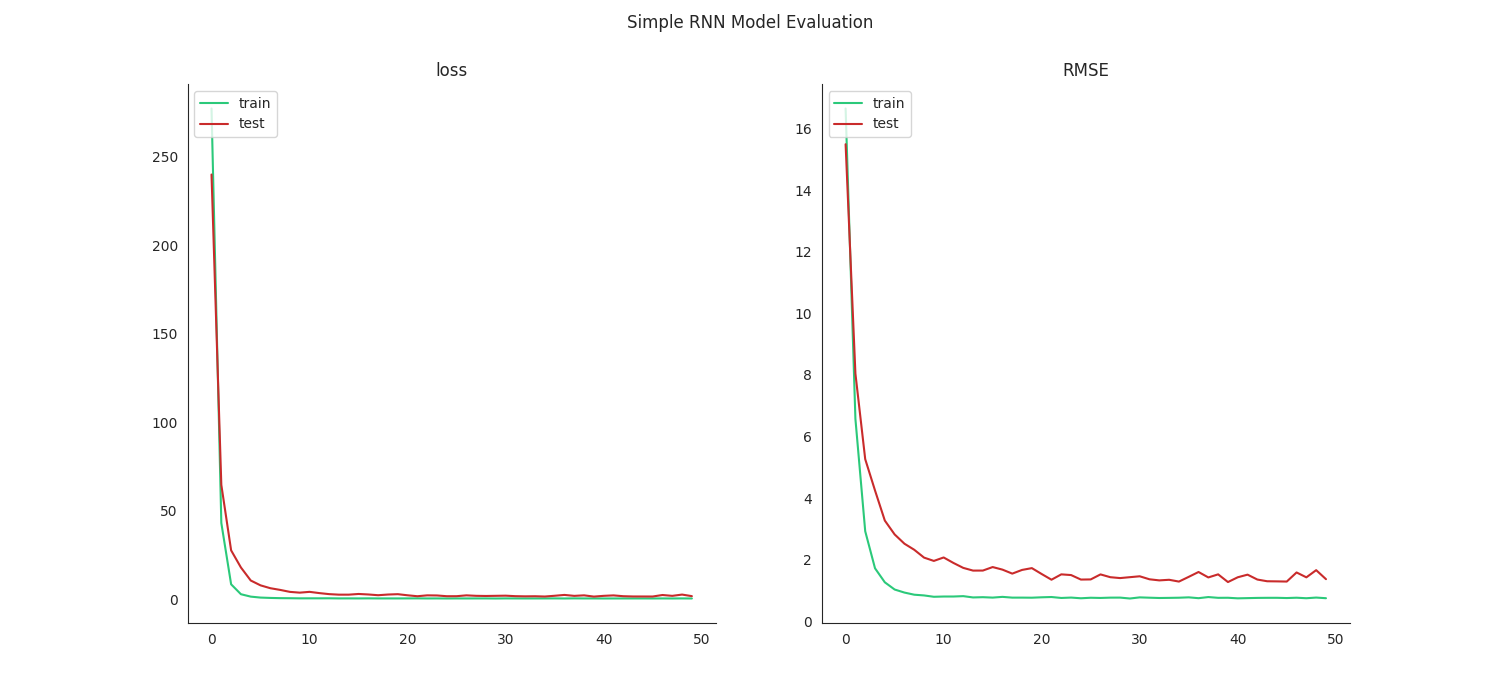

In [72]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Simple RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')


In [73]:
from sklearn.metrics import mean_squared_error

y_pred_srnn = model.predict(X_test) 


38/38 [==============================] - 0s 3ms/step


In [74]:
# Create a DataFrame to compare actual and predicted values for simple RNN model
comparison_srnn = pd.DataFrame()
comparison_srnn['actual'] = y_test.flatten()
comparison_srnn['predicted'] = y_pred_srnn.flatten()
comparison_srnn["Residuals"] = y_pred_srnn.flatten() -y_test.flatten()
# Print the first 10 rows of the DataFrame
print(comparison_srnn.head(10))

      actual  predicted  Residuals
0  51.139999  51.295757   0.155758
1  52.799999  51.784157  -1.015842
2  53.000000  54.065987   1.065987
3  51.990002  54.136295   2.146294
4  52.240002  53.165157   0.925156
5  51.680000  53.167896   1.487896
6  51.660000  52.724411   1.064411
7  53.980000  52.425350  -1.554649
8  54.459999  54.794468   0.334469
9  53.790001  55.283695   1.493694


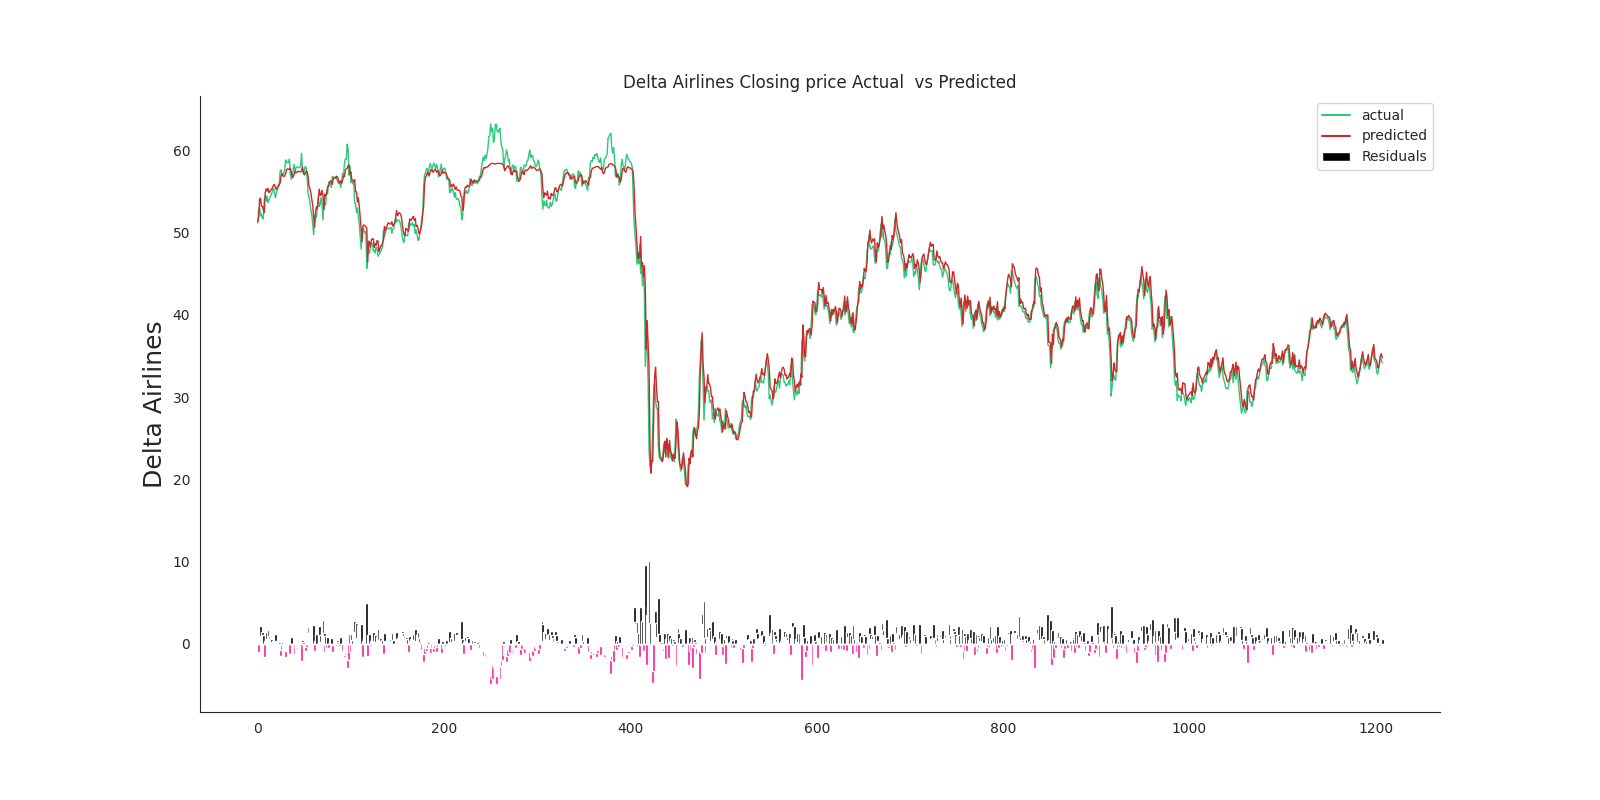

In [75]:
%matplotlib widget
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Delta Airlines Closing price Actual  vs Predicted")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#2BC97A", "#C92B2B"])
sns.lineplot(data=comparison_srnn[['actual', 'predicted']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# note: I need to separate this from the close versus predicted plot - otherwise, it can be too small to read
df_sub = ["#000000" if x > 0 else "#FF1493" for x in comparison_srnn["Residuals"].dropna()]
ax1.bar(height=comparison_srnn['Residuals'].dropna(), x=comparison_srnn['Residuals'].dropna().index, width=3, label='Residuals', color=df_sub)
plt.legend()
plt.show()

# LSTM with more layers

In [76]:
model = keras.models.Sequential([
    keras.layers.LSTM(100, activation='tanh', return_sequences=True, input_shape=[3, 4]),
    keras.layers.LSTM(100, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [77]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [78]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_test, y_test), batch_size=10, verbose=1)


Epoch 1/50
282/282 [==============================] - 11s 19ms/step - loss: 259.9942 - root_mean_squared_error: 16.1243 - val_loss: 190.7397 - val_root_mean_squared_error: 13.8109
Epoch 2/50
282/282 [==============================] - 3s 12ms/step - loss: 31.3030 - root_mean_squared_error: 5.5949 - val_loss: 51.3392 - val_root_mean_squared_error: 7.1651
Epoch 3/50
282/282 [==============================] - 3s 12ms/step - loss: 6.1814 - root_mean_squared_error: 2.4863 - val_loss: 22.9587 - val_root_mean_squared_error: 4.7915
Epoch 4/50
282/282 [==============================] - 3s 9ms/step - loss: 2.3947 - root_mean_squared_error: 1.5475 - val_loss: 14.0108 - val_root_mean_squared_error: 3.7431
Epoch 5/50
282/282 [==============================] - 2s 8ms/step - loss: 1.3650 - root_mean_squared_error: 1.1683 - val_loss: 9.2315 - val_root_mean_squared_error: 3.0383
Epoch 6/50
282/282 [==============================] - 2s 6ms/step - loss: 0.9555 - root_mean_squared_error: 0.9775 - val_loss:

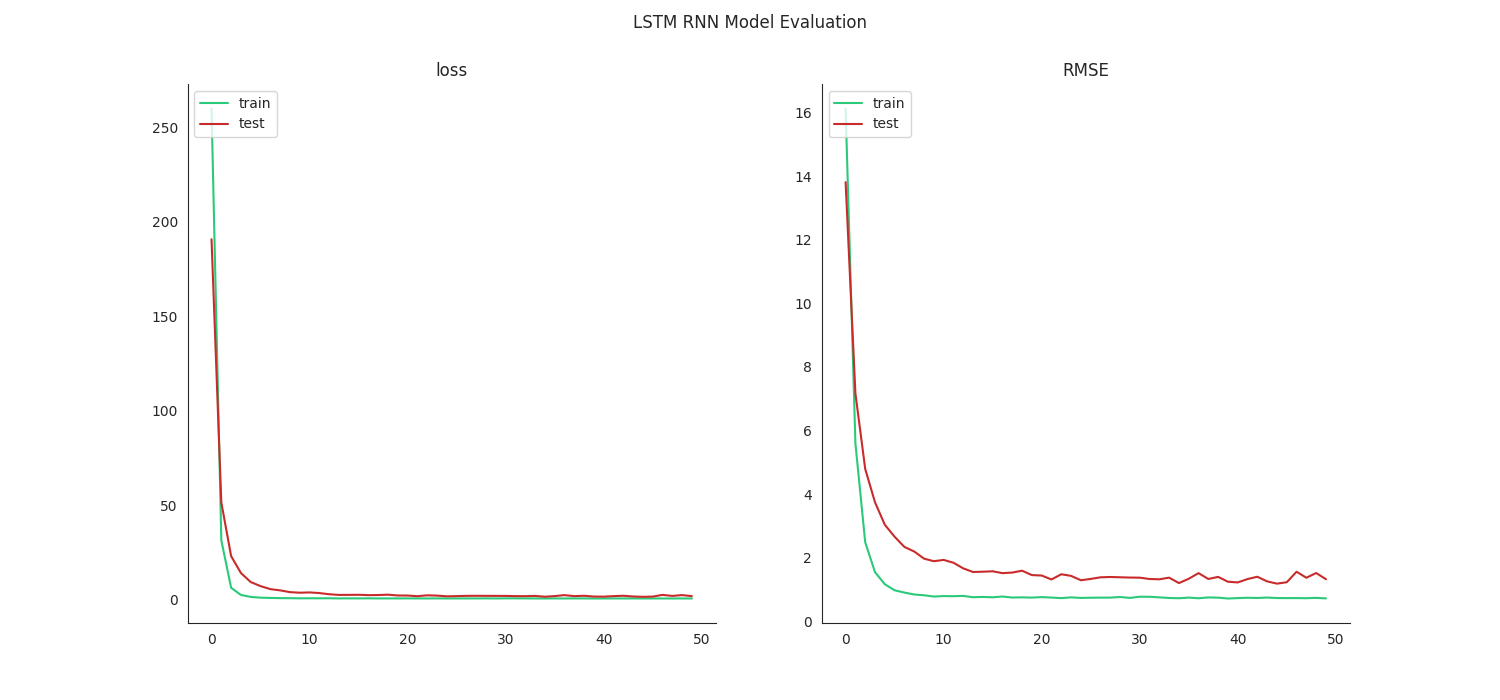

In [79]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [80]:

y_pred = model.predict(X_test) 
# Create a DataFrame to compare actual and predicted values
comparison_lrnn = pd.DataFrame()
comparison_lrnn['actual'] = y_test.flatten()
comparison_lrnn['predicted'] = y_pred.flatten()
comparison_lrnn["Residuals"] = y_pred.flatten() -y_test.flatten()
# Print the first 10 rows of the DataFrame
print(comparison_lrnn.head(10))

38/38 [==============================] - 1s 2ms/step
      actual  predicted  Residuals
0  51.139999  51.551792   0.411793
1  52.799999  52.247902  -0.552097
2  53.000000  54.011402   1.011402
3  51.990002  54.098091   2.108089
4  52.240002  53.249866   1.009865
5  51.680000  53.250149   1.570148
6  51.660000  52.870029   1.210030
7  53.980000  52.743465  -1.236534
8  54.459999  54.706291   0.246292
9  53.790001  55.506966   1.716965


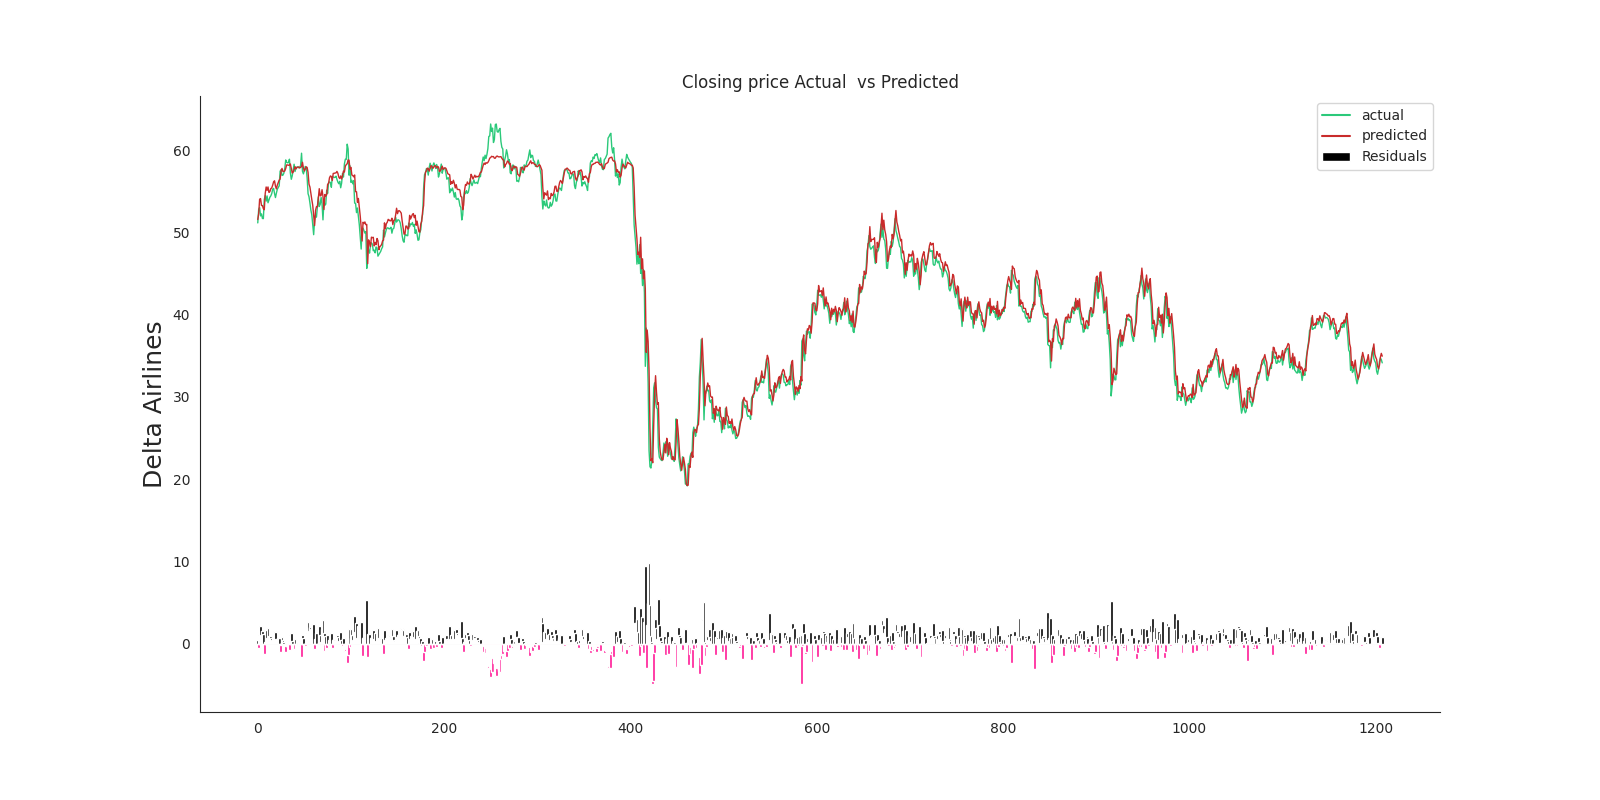

In [81]:
%matplotlib widget
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Closing price Actual  vs Predicted")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#2BC97A", "#C92B2B"])
sns.lineplot(data=comparison_lrnn[['actual', 'predicted']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# note: I need to separate this from the close versus predicted plot - otherwise, it can be too small to read
df_sub = ["#000000" if x > 0 else "#FF1493" for x in comparison_lrnn["Residuals"].dropna()]
ax1.bar(height=comparison_lrnn['Residuals'].dropna(), x=comparison_lrnn['Residuals'].dropna().index, width=3, label='Residuals', color=df_sub)
plt.legend()
plt.show()

# Part-3 Model Performance Evaluation

In [82]:
print("\033[1mModel Performance Evaluation for Simple RNN model\033[0m")

# Mean Squared Error (MSE)
MSE = mean_squared_error(comparison_srnn['actual'], comparison_srnn['predicted'])
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(comparison_srnn['actual'], comparison_srnn['predicted'])
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(comparison_srnn['actual'], comparison_srnn['predicted'])/ comparison_srnn['actual']))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(comparison_srnn['actual'], comparison_srnn['predicted'])/ comparison_srnn['actual'])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
print("**********************************************************************************************************************************")
print("\033[1mModel Performance Evaluation for LSTM RNN model\033[0m")
# Mean Squared Error (MSE)
MSE = mean_squared_error(comparison_lrnn['actual'], comparison_lrnn['predicted'])
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(comparison_lrnn['actual'], comparison_lrnn['predicted'])
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(comparison_lrnn['actual'], comparison_lrnn['predicted'])/ comparison_lrnn['actual']))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(comparison_lrnn['actual'], comparison_lrnn['predicted'])/ comparison_lrnn['actual'])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Model Performance Evaluation for Simple RNN model
Mean Squared Error (MSE): 1.88
Mean Absolute Error (MAE): 1.01
Mean Absolute Percentage Error (MAPE): 2.53 %
Median Absolute Percentage Error (MDAPE): 1.91 %
**********************************************************************************************************************************
Model Performance Evaluation for LSTM RNN model
Mean Squared Error (MSE): 1.76
Mean Absolute Error (MAE): 0.98
Mean Absolute Percentage Error (MAPE): 2.46 %
Median Absolute Percentage Error (MDAPE): 1.81 %


# **Analysis**


---
Based on the above performance evaluation values, both the Simple RNN and LSTM RNN models have performed reasonably well in predicting Delta Airlines' closing price.

The Mean Squared Error (MSE) is an important metric that measures the average squared difference between the predicted and actual values. In this case, the MSE for the Simple RNN model is 1.88, while for the LSTM RNN model, it's 1.76. This indicates that the LSTM model is slightly better at predicting the closing price than the Simple RNN model.

The Mean Absolute Error (MAE) is another important metric that measures the average absolute difference between the predicted and actual values. The MAE for the Simple RNN model is 1.01, while for the LSTM RNN model, it's 0.98. This indicates that the LSTM model is slightly better at predicting the closing price than the Simple RNN model.

The Mean Absolute Percentage Error (MAPE) is a useful metric that measures the average percentage difference between the predicted and actual values. The MAPE for the Simple RNN model is 2.53%, while for the LSTM RNN model, it's 2.46%. This indicates that both models have performed similarly in terms of predicting the closing price with respect to the percentage error.

The Median Absolute Percentage Error (MDAPE) is another useful metric that measures the median percentage difference between the predicted and actual values. The MDAPE for the Simple RNN model is 1.91%, while for the LSTM RNN model, it's 1.81%. This indicates that both models have performed similarly in terms of predicting the closing price with respect to the median percentage error.

In conclusion, based on the performance metrics, the LSTM RNN model has performed slightly better than the Simple RNN model in predicting Delta Airlines' closing price.

